# To-do
## Code
* Move code to .py file
* Vim keybindings?
* There's a lot of swapping back between npc and np arrays, possible to keep in just npc
* Rather than manually running for N steps, set convergence criteria. Upon convergence, unitarize once more re-run.
* Maybe make the testdata object in the gradient descent step a dictionary or named tuple... (or an object...)
    * There's a nice OOP structure possible here. The problem is we might be moving to Julia!

## Unitary optimization
* Implement gradient descent function with M replaced by M+epsilon, and set epsilon to 0 past a certain threshold.
    * Use different learning rates for each region?
* May need to speed up gradient step for large number of unitaries by reducing duplication of effort in matrix multiplications.
* Not only can M vanish, but dM/dU can vanish at M=0 due to symmetry. (Verify?) So could do a similar procedure for dM/dU, for M near 0 rather than multiplying by a scalar can set the vector M*dM/dU to a certain magnitude.
    * Can go even further with this idea. We've seen numerically that multiplying the gradient by a large number works well. Could use to randomly seed many possible starting points and then switch to ordinary gradient descent to find optimal. (This might be a way to avoid local minima.
    * Alternatively, could take the magnitude of the scalar factor to infinity! Calculate the gradient, project onto anti-hermitian subspace, the unitarize. In low dimensions, intuitively this somehow gives an "orthogonal" matrix. However there is no guarantee the resulting matrix is close to unitary...
### Converging to non-global local minima.
* See large gradient seeding idea above.
* Could adapt loss function to include a term so that the solution is orthogonal to a previously found solution?
### Riemannian  optimization
* Libraries for this with many different optimization schemes. Should try out, but the main one is in Julia.

## Cohomology phase extraction
* Should extract cohomology phase during learning. The phase is extracting cleanly even for noisy solutions.
* Where is the phase coming from in the unitaries?
* Should be more general, apply formula for non-abelian symmetries. Not necessarily gauge invariant.

## $M=0$ subspace
* Is the high probability for M vanishing a general property, not just for the phase/wavefunctions here?
    * It would be nice to describe the manifold in $SU(N)^{2w}$ for which M vanishes. Not quite linear subspace, but multilinear. So better defined in $M(N,N)^{2w}$? Can easily restrict afterwards. Would even settle for caluclating the dimension of this manifold.
    *  Note that the zeroes of $M$ seem closely related to vanishing string order parameters and also the expectations of operators defined on small number of sites.
    *  Could this be used as a quick test for a non-trivial SPT?
    *  Could probably work this out exactly for the cluster model. How does the manifold change with $B$? Intuitively the dimension of the manifold should be an invariant of the phase...!
    *  The zeroes are also important once a solution for $M=1$ is found. If there are more than one $U$ for $M=1$, then the difference in $U$ should belong to this zero manifold. Is the converse true...? (Unlikely.)
### Finding the subspace
* Difficulty with calculating in general is that $M$ is a multilinear function of $U_i$...
* Suppose that we are at $M=0$. If we pick out $U_k$ to vary and leave the other $U_i$ fixed, then we have a linear problem. Can find the corresponding "kernel" easily enough...? Just move perpendicularly to the gradient. However we have already observed that $dM/dU_k$ will likely vanish for $M=0$. Would the Hessian be sufficient? The issue with the Hessian is that technically we should include terms from two of the $U_i$... Should try to work out on paper.
* Could work out via linear algebra by figuring out what unitaries "zero out" the relevant transfer matrix. Alternatively if one had the left and right environments specified, this could be computed exactly.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

In [3]:
from tenpy.networks.site import SpinSite, SpinHalfSite
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel

from tenpy.linalg.np_conserved import Array as npc_Array

In [4]:
import h5py
from tenpy.tools import hdf5_io

import os

# Load data

In [5]:
DATA_DIR = r"data/transverse_cluster_100_site_dmrg"

In [6]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

# Optimize gradient descent

In [7]:
loaded_data[0]

{'paramters': {'B': 1.3},
 'wavefunction': <tenpy.networks.mps.MPS at 0x79a9d254ea90>}

In [8]:
test_psi = loaded_data[0]['wavefunction']

In [9]:
test_psi.get_B(0)

<npc.Array shape=(1, 2, 2) labels=['vL', 'p', 'vR']>

In [10]:
test_psi.get_B(0)

<npc.Array shape=(1, 2, 2) labels=['vL', 'p', 'vR']>

In [11]:
test_psi.canonical_form_finite()

In [12]:
test_psi.expectation_value("Sigmax", 50)

array([0.82995681])

In [13]:
B_test = test_psi.get_B(50)

In [14]:
left_leg = B_test.legs[0]

In [15]:
SL_test = npc.diag(test_psi.get_SL(50), left_leg, labels = ['vL', 'vR'])

In [16]:
SL_test

<npc.Array shape=(8, 8) labels=['vL', 'vR']>

In [17]:
B_test

<npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>

In [18]:
def to_npc_array(np_X):
    npc_X = (
        npc_Array
        .from_ndarray_trivial(
            np.array(np_X, dtype='complex'),
            dtype=np.complex_,
            labels=['p', 'p*']
        )
    )
    return npc_X

In [19]:
npc_X = (
    npc_Array
    .from_ndarray_trivial(
        np.array([[0,1],[1,0]], dtype='complex'),
        dtype=np.complex_,
        labels=['p', 'p*']
    )
)

In [20]:
npc_X

<npc.Array shape=(2, 2) labels=['p', 'p*']>

In [21]:
def partial_contract_ops(psi, ops_list, starting_index):
    B0 = psi.get_B(starting_index)
    op0 = ops_list[0]

    t = npc.tensordot(B0, op0, (['p',], ['p*',]))
    t = npc.tensordot(t, B0.conj(), (['p',], ['p*',]))
    
    for i, op in enumerate(ops_list[1:], start=starting_index + 1):
        b = psi.get_B(i)
        t = npc.tensordot(t, b, (['vR',], ['vL',]))
        t = npc.tensordot(t, b.conj(), (['vR*',], ['vL*',]))
        t = npc.tensordot(t, op, (['p', 'p*'], ['p*', 'p']))

    return t

In [22]:
starting_index = 40
ops_list = [npc_X,]*20

In [23]:
B0 = test_psi.get_B(starting_index)

In [24]:
test_psi.L

100

In [25]:
B0

<npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>

In [26]:
op0 = ops_list[0]

In [27]:
t = npc.tensordot(B0, op0, (['p',], ['p*',]))
t = npc.tensordot(t, B0.conj(), (['p',], ['p*',]))

In [28]:
t

<npc.Array shape=(8, 8, 8, 8) labels=['vL', 'vR', 'vL*', 'vR*']>

In [29]:
test_t = partial_contract_ops(test_psi, [npc_X,]*20, 40)

In [30]:
test_t

<npc.Array shape=(8, 8, 8, 8) labels=['vL', 'vL*', 'vR', 'vR*']>

In [31]:
test_psi.expectation_value_multi_sites([npc_X,]*20, 40)

array(0.64194101)

In [32]:
exp_test_t = npc.trace(test_t, leg1='vR', leg2='vR*')

In [33]:
left_leg = test_psi.get_B(40).legs[0]
exp_SL_test = npc.diag(test_psi.get_SL(40), left_leg, labels = ['vL', 'vR'])

In [34]:
exp_test_t = npc.tensordot(exp_test_t, exp_SL_test, (['vL',], ['vR',]))
exp_test_t = npc.tensordot(exp_test_t, exp_SL_test.conj(), (['vL*',], ['vR*',]))

In [35]:
npc.trace(exp_test_t, leg1='vL', leg2='vL*')

(0.6419410096319128+0j)

In [36]:
def multiply_transfer_matrices(t1, t2):
    return npc.tensordot(t1, t2, (['vR', 'vR*'], ['vL', 'vL*']))

In [37]:
def multiply_transfer_matrices_from_right(t1, t2):
    return npc.tensordot(t1, t2, (['vL', 'vL*'], ['vR', 'vR*']))

In [38]:
def get_transfer_matrix_from_unitary(psi, unitary, index):
    u = to_npc_array(unitary)
    b = psi.get_B(index)
    t = npc.tensordot(b, u, (['p',], ['p*']))
    t = npc.tensordot(t, b.conj(), (['p',], ['p*']))
    return t

In [39]:
def get_transfer_matrices_from_unitary_list(psi, unitaries, starting_index):
    transfer_matrices = [
        get_transfer_matrix_from_unitary(psi, u, i)
        for i, u in enumerate(unitaries, start=starting_index)
    ]
    return transfer_matrices

In [40]:
from functools import reduce

In [41]:
def matrix_element(left_environment, left_transfer_matrices,
                   symmetry_block_tm, right_transfer_matrices):
    transfer_matrices = (
        left_transfer_matrices +
        [symmetry_block_tm,] +
        right_transfer_matrices
    )

    t_with_open_right_end = reduce(
        multiply_transfer_matrices,
        transfer_matrices,
        left_environment
    )

    return npc.trace(t_with_open_right_end, leg1='vR', leg2='vR*')

In [42]:
from itertools import accumulate

In [43]:
from operator import mul

In [44]:
len(range(5))

5

In [45]:
list(accumulate(range(1,5), mul, initial=10))

[10, 10, 20, 60, 240]

In [46]:
test_psi.get_B(0)

<npc.Array shape=(1, 2, 2) labels=['vL', 'p', 'vR']>

In [47]:
test_A = test_psi.get_B(0)

In [48]:
print(npc.eye_like(test_A, axis=-1, labels = ['vL', 'vL*']))

<npc.Array shape=(2, 2) labels=['vL', 'vL*']
charge=ChargeInfo([], [])
 -1 | +1 
0 []|0 []
2   |2   
[[1. 0.]
 [0. 1.]]
>


In [49]:
def get_matrix_gradient(psi, index, environment_left_of_site,
                        environment_right_of_site):
    b = psi.get_B(index)
    t = npc.tensordot(environment_left_of_site, b.conj(), (['vR*',], ['vL*',]))
    t = npc.tensordot(t, b, (['vR',], ['vL',]))
    t = npc.tensordot(t, environment_right_of_site, (['vR','vR*'], ['vL', 'vL*']))

    return t.to_ndarray()

In [50]:
l = list(range(10))

In [51]:
l[:5]

[0, 1, 2, 3, 4]

In [52]:
l[:1]

[0]

In [53]:
l

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [54]:
l[-1]

9

In [55]:
def matrix_element_and_gradients(psi, left_environment, left_transfer_matrices,
    symmetry_block_tm, right_transfer_matrices, starting_index,
    len_symmetry_block):

    ending_index = (
        starting_index +
        len(left_transfer_matrices) +
        len_symmetry_block +
        len(right_transfer_matrices)
        -1
    )
    
    right_environment = npc.eye_like(
        psi.get_B(ending_index),
        axis=-1,
        labels = ['vL', 'vL*'],
    )
    
    all_tms = (
        left_transfer_matrices +
        [symmetry_block_tm,] +
        right_transfer_matrices
    )
    
    tms_products_from_left = list(accumulate(
        all_tms, multiply_transfer_matrices, initial=left_environment
    ))
    
    tms_products_from_right = list(accumulate(
        all_tms[::-1],
        multiply_transfer_matrices_from_right,
        initial=right_environment
    ))

    matrix_element = npc.trace(
        tms_products_from_left[-1], leg1='vR', leg2='vR*'
    )

    left_grads_iter = enumerate(
        tms_products_from_left[:len(left_transfer_matrices)]
    )

    left_matrix_gradients = list()
    for i, left_environment in left_grads_iter:
        right_environment = tms_products_from_right[-i-2]
        psi_index = i + starting_index
        gradient = get_matrix_gradient(
            psi, psi_index, left_environment, right_environment
        )
        left_matrix_gradients.append(gradient)

    right_grads_iter = enumerate(
        tms_products_from_right[:len(right_transfer_matrices)]
    )

    right_matrix_gradients = list()
    for i, right_environment in right_grads_iter:
        left_environment = tms_products_from_left[-i-2]
        psi_index = ending_index - i
        gradient = get_matrix_gradient(
            psi, psi_index, left_environment, right_environment
        )
        right_matrix_gradients.append(gradient)

    return (matrix_element, left_matrix_gradients, right_matrix_gradients[::-1])

In [56]:
def matrix_gradient_left_unitary(psi, left_environment, left_transfer_matrices,
                    symmetry_block_tm, right_transfer_matrices,
                    psi_index, unitary_index):

    environment_left_of_site = reduce(
        multiply_transfer_matrices,
        left_transfer_matrices[:unitary_index],
        left_environment
    )

    environment_right_of_site = reduce(
        multiply_transfer_matrices,
        (
            left_transfer_matrices[unitary_index+1:] +
            [symmetry_block_tm,] +
            right_transfer_matrices
        )
    )

    environment_right_of_site = npc.trace(
        environment_right_of_site, leg1='vR', leg2='vR*'
    )

    b = psi.get_B(psi_index)
    t = npc.tensordot(environment_left_of_site, b.conj(), (['vR*',], ['vL*',]))
    t = npc.tensordot(t, b, (['vR',], ['vL',]))
    t = npc.tensordot(t, environment_right_of_site, (['vR','vR*'], ['vL', 'vL*']))

    """
    if t.get_leg_index('p') == 1:
        t.itranspose()
    """

    return t.to_ndarray()

In [57]:
def matrix_gradient_right_unitary(psi, left_environment, left_transfer_matrices,
                    symmetry_block_tm, right_transfer_matrices,
                    psi_index, unitary_index):

    environment_left_of_site = reduce(
        multiply_transfer_matrices,
        (
            left_transfer_matrices +
            [symmetry_block_tm,] + 
            right_transfer_matrices[:unitary_index]
        ),
        left_environment
    )

    b = psi.get_B(psi_index)
    t = npc.tensordot(environment_left_of_site, b.conj(), (['vR*',], ['vL*',]))
    t = npc.tensordot(t, b, (['vR',], ['vL',]))

    
    t = reduce(
        multiply_transfer_matrices,
        right_transfer_matrices[unitary_index+1:],
        t
    )

    t = npc.trace(t, leg1='vR', leg2='vR*')

    """
    if t.get_leg_index('p') == 1:
        t.itranspose()
    """
    
    return t.to_ndarray()

In [58]:
def compute_symmetry_block_transfer_matrix(psi, symmetry_op_list, starting_index):
    transfer_matrices = (
        get_transfer_matrix_from_unitary(psi, op, index)
        for index, op in enumerate(symmetry_op_list, start=starting_index)
    )

    symmetry_block_transfer_matrix = reduce(
        multiply_transfer_matrices,
        transfer_matrices
    )

    return symmetry_block_transfer_matrix

In [59]:
from scipy.stats import unitary_group

In [60]:
unitary_sampler = unitary_group(2)

In [61]:
np_I = np.array([[1,0], [0,1]])
np_X = np.array([[0,1], [1,0]])
np_Y = np.array([[0,-1j], [1j, 0]])
np_Z = np.array([[1,0],[0,-1]])

In [62]:
pauli_matrices = [np_I, np_X, np_Y, np_Z]

In [63]:
from itertools import product

In [64]:
def initialize_unitaries(psi, left_environment, num_unitary_width,
                         symmetry_block_tm, starting_index, len_symmetry_block):
    left_unitaries = [unitary_sampler.rvs() for _ in range(num_unitary_width)]
    right_unitaries = [unitary_sampler.rvs() for _ in range(num_unitary_width)]

    left_transfer_matrices = list()
    for i, u in enumerate(left_unitaries, start=starting_index):
        l = list()
        for p in pauli_matrices:
            up = u.dot(p)
            tm = get_transfer_matrix_from_unitary(psi, up, i)
            l.append(tm)
        left_transfer_matrices.append(l)

    
    right_transfer_matrices = list()
    start = starting_index + num_unitary_width + len_symmetry_block
    for i, u in enumerate(right_unitaries, start=start):
        l = list()
        for p in pauli_matrices:
            up = u.dot(p)
            tm = get_transfer_matrix_from_unitary(psi, up, i)
            l.append(tm)
        right_transfer_matrices.append(l)

    left_transfer_matrix_index_enumerator = product(
        *([range(len(pauli_matrices)),]*num_unitary_width)
    )
    
    right_transfer_matrix_index_enumerator = product(
        *([range(len(pauli_matrices)),]*num_unitary_width)
    )

    min_loss = 1.0
    
    for u_l, i_l in zip(product(*left_transfer_matrices), left_transfer_matrix_index_enumerator):
        for u_r, i_r in zip(product(*right_transfer_matrices), right_transfer_matrix_index_enumerator):
            m = matrix_element(
                left_environment, list(u_l), symmetry_block_tm, list(u_r)
            )
            loss = 1-np.abs(m)**2
            if loss < min_loss:
                min_loss = loss
                i_l_min = i_l
                i_r_min = i_r

    for i, index in enumerate(i_l_min):
        u = left_unitaries[i].dot(pauli_matrices[index])
        left_unitaries[i] = u

    for i, index in enumerate(i_r_min):
        u = right_unitaries[i].dot(pauli_matrices[index])
        right_unitaries[i] = u

    return (left_unitaries, right_unitaries)

In [65]:
def grad_descent_setup(psi, num_unitary_width, symmetry_op_list):
    # Initialize unitaries, using "grid" search.
    # Compute symmetry_block_tm

    num_sites = psi.L
    num_symmetry_sites = len(symmetry_op_list)
    num_unitary_sites = num_unitary_width*2

    starting_index = (num_sites - (num_symmetry_sites + num_unitary_sites))//2
    symmetry_starting_index = starting_index + num_unitary_width

    left_leg = psi.get_B(starting_index).legs[0]
    SL = npc.diag(psi.get_SL(starting_index), left_leg, labels = ['vL', 'vR'])
    left_environment = npc.tensordot(SL, SL.conj(), (['vL',], ['vL*',]))

    symmetry_block_transfer_matrix = compute_symmetry_block_transfer_matrix(
        psi, symmetry_op_list, symmetry_starting_index
    )

    left_unitaries = [unitary_sampler.rvs() for _ in range(num_unitary_width)]
    right_unitaries = [unitary_sampler.rvs() for _ in range(num_unitary_width)]
    
    losses = list()
    unitary_scores = list()

    out = (
        psi,
        left_environment,
        symmetry_block_transfer_matrix,
        left_unitaries,
        right_unitaries,
        starting_index,
        num_symmetry_sites,
        losses,
        unitary_scores
    )

    return out

In [66]:
def projector(U, delta_U):
    M1 = (U.conj().T).dot(delta_U)
    M2 = 0.5*(M1 - M1.conj().T)
    M3 = U.dot(M2)

    return M3

In [67]:
UNITARY_TOL = 0.005

In [68]:
def unitary_test(U):
    return np.max(np.abs(U.conj().T.dot(U)-np.identity(len(U))))

In [69]:
def unitarize_matrix(U):
    L,S,R = np.linalg.svd(U)
    return L.dot(R)

In [70]:
def loss(psi, symmetry_operations, left_unitaries, right_unitaries):
    M = matrix_element(psi, symmetry_operations, left_unitaries, right_unitaries)
    return 1 - np.abs(M)**2

In [71]:
def grad_descent_step(psi, left_environment, symmetry_block_tm, left_unitaries,
                      right_unitaries, starting_index, len_symmetry_block,
                      losses, unitary_scores, eta=0.03):
    
    left_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, left_unitaries, starting_index
    )
    right_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, right_unitaries, starting_index + len(left_unitaries) + len_symmetry_block
    )
    
    expectation, left_matrix_gradients, right_matrix_gradients = (
        matrix_element_and_gradients(
            psi,
            left_environment,
            left_transfer_matrices,
            symmetry_block_tm,
            right_transfer_matrices,
            starting_index,
            len_symmetry_block
        )
    )

    abs_exp = np.abs(expectation)
    pol_exp = expectation/abs_exp

    """
    if abs_exp < 0.9:
        m = pol_exp
    else:
        m = expectation
    """

    for i, m_grad in enumerate(left_matrix_gradients):
        u = left_unitaries[i]
        u_grad = -2*pol_exp*np.conj(m_grad)
        left_unitaries[i] += -eta*projector(u, u_grad)

    for i, m_grad in enumerate(right_matrix_gradients):
        u = right_unitaries[i]
        u_grad = -2*pol_exp*np.conj(m_grad)
        right_unitaries[i] += -eta*projector(u, u_grad)

    all_unitaries = left_unitaries + right_unitaries

    any_unitary_fail = any(
        unitary_test(u) > UNITARY_TOL
        for u in all_unitaries
    )

    if any_unitary_fail:
        for i in range(len(left_unitaries)):
            u = left_unitaries[i]
            left_unitaries[i] = unitarize_matrix(u)
        for i in range(len(right_unitaries)):
            u = right_unitaries[i]
            right_unitaries[i] = unitarize_matrix(u)

    unitary_score = max(unitary_test(u) for u in left_unitaries + right_unitaries)
    unitary_scores.append(unitary_score)

    losses.append(1 - np.abs(expectation))

In [72]:
"""
def grad_descent_step(psi, left_environment, symmetry_block_tm, left_unitaries,
                      right_unitaries, starting_index, len_symmetry_block,
                      losses, unitary_scores, eta=0.03):
    
    left_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, left_unitaries, starting_index
    )
    right_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, right_unitaries, starting_index + len(left_unitaries) + len_symmetry_block
    )
    
    expectation = matrix_element(
        left_environment, left_transfer_matrices, symmetry_block_tm,
        right_transfer_matrices
    )

    left_matrix_gradients = list()
    for i, u in enumerate(left_transfer_matrices):
        psi_index = starting_index + i
        grad = matrix_gradient_left_unitary(
            psi, left_environment, left_transfer_matrices, symmetry_block_tm,
            right_transfer_matrices, psi_index, i
        )
        left_matrix_gradients.append(grad)

    right_matrix_gradients = list()
    for i, u in enumerate(right_transfer_matrices):
        psi_index = (
            starting_index +
            len_symmetry_block +
            len(left_unitaries) +
            i
        )
        grad = matrix_gradient_right_unitary(
            psi, left_environment, left_transfer_matrices, symmetry_block_tm,
            right_transfer_matrices, psi_index, i
        )
        right_matrix_gradients.append(grad)

    abs_exp = np.abs(expectation)
    pol_exp = expectation/abs_exp
    
    if abs_exp < 0.9:
        m = pol_exp
    else:
        m = expectation
    
    for i, m_grad in enumerate(left_matrix_gradients):
        u = left_unitaries[i]
        u_grad = -2*m*np.conj(m_grad)
        left_unitaries[i] += -eta*projector(u, u_grad)

    for i, m_grad in enumerate(right_matrix_gradients):
        u = right_unitaries[i]
        u_grad = -2*m*np.conj(m_grad)
        right_unitaries[i] += -eta*projector(u, u_grad)

    all_unitaries = left_unitaries + right_unitaries

    any_unitary_fail = any(
        unitary_test(u) > UNITARY_TOL
        for u in all_unitaries
    )

    if any_unitary_fail:
        for i in range(len(left_unitaries)):
            u = left_unitaries[i]
            left_unitaries[i] = unitarize_matrix(u)
        for i in range(len(right_unitaries)):
            u = right_unitaries[i]
            right_unitaries[i] = unitarize_matrix(u)

    unitary_score = max(unitary_test(u) for u in left_unitaries + right_unitaries)
    unitary_scores.append(unitary_score)

    losses.append(1 - np.abs(expectation)**2)
"""

'\ndef grad_descent_step(psi, left_environment, symmetry_block_tm, left_unitaries,\n                      right_unitaries, starting_index, len_symmetry_block,\n                      losses, unitary_scores, eta=0.03):\n    \n    left_transfer_matrices = get_transfer_matrices_from_unitary_list(\n        psi, left_unitaries, starting_index\n    )\n    right_transfer_matrices = get_transfer_matrices_from_unitary_list(\n        psi, right_unitaries, starting_index + len(left_unitaries) + len_symmetry_block\n    )\n    \n    expectation = matrix_element(\n        left_environment, left_transfer_matrices, symmetry_block_tm,\n        right_transfer_matrices\n    )\n\n    left_matrix_gradients = list()\n    for i, u in enumerate(left_transfer_matrices):\n        psi_index = starting_index + i\n        grad = matrix_gradient_left_unitary(\n            psi, left_environment, left_transfer_matrices, symmetry_block_tm,\n            right_transfer_matrices, psi_index, i\n        )\n        left_matr

# Testing

In [73]:
loaded_data[0]

{'paramters': {'B': 1.3},
 'wavefunction': <tenpy.networks.mps.MPS at 0x79a9d254ea90>}

In [74]:
psi = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0
)   

In [75]:
(
    psi,
    left_environment,
    symmetry_block_tm,
    left_unitaries,
    right_unitaries,
    starting_index,
    len_symmetry_block,
    losses,
    unitary_scores
) = grad_descent_setup(psi, 2, [np_X, np_I]*10)

In [76]:
for _ in range(100):
    grad_descent_step(
        psi,
        left_environment,
        symmetry_block_tm,
        left_unitaries,
        right_unitaries,
        starting_index,
        len_symmetry_block,
        losses,
        unitary_scores,
        eta=0.1
    )

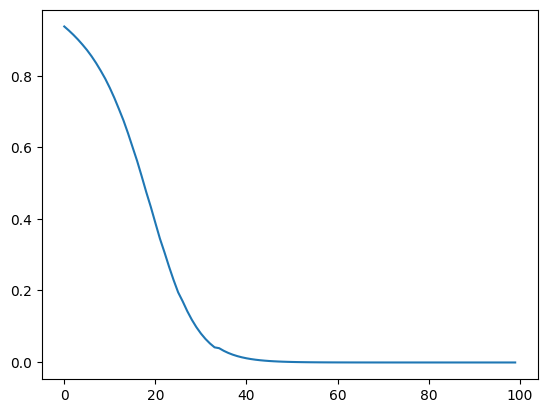

In [77]:
plt.plot(losses)

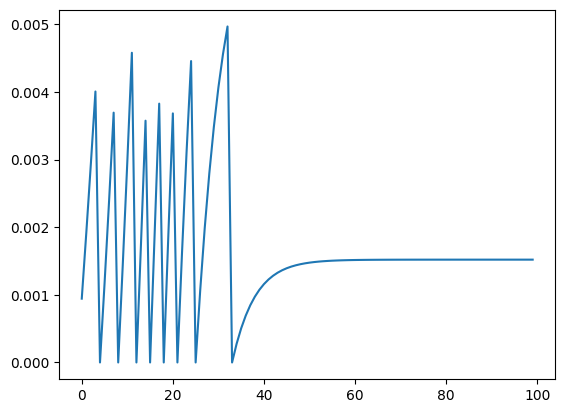

In [78]:
plt.plot(unitary_scores)

In [79]:
losses[-1]

-0.0019990000861964674

Other symmetry action

In [80]:
data_b0_s2 = grad_descent_setup(psi, 2, [np_X, np_X]*10)

In [81]:
for _ in range(100):
    grad_descent_step(*data_b0_s2, eta=0.1)

In [82]:
(*_, losses, unitary_scores) = data_b0_s2

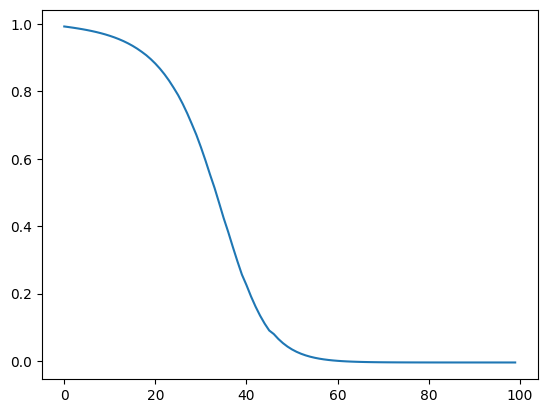

In [83]:
plt.plot(losses)

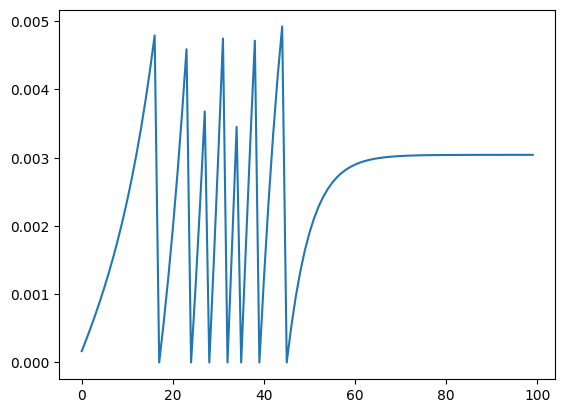

In [84]:
plt.plot(unitary_scores)

### Extract cohomology class

In [85]:
(
    psi,
    left_environment,
    symmetry_block_tm,
    left_unitaries,
    right_unitaries,
    starting_index,
    len_symmetry_block,
    losses,
    unitary_scores
) = grad_descent_setup(psi, 2, [np_X, np_I]*10)

In [86]:
def get_transfer_matrices_from_unitary_list(psi, unitaries, starting_index):
    transfer_matrices = [
        get_transfer_matrix_from_unitary(psi, u, i)
        for i, u in enumerate(unitaries, start=starting_index)
    ]
    return transfer_matrices

In [87]:
from functools import reduce

In [88]:
def matrix_element(left_environment, left_transfer_matrices,
                   symmetry_block_tm, right_transfer_matrices):
    transfer_matrices = (
        left_transfer_matrices +
        [symmetry_block_tm,] +
        right_transfer_matrices
    )

    t_with_open_right_end = reduce(
        multiply_transfer_matrices,
        transfer_matrices,
        left_environment
    )

    return npc.trace(t_with_open_right_end, leg1='vR', leg2='vR*')

In [164]:
"""
This was a previous implementation of the cohomology phase extraction I was working on.
Turns out we don't need the exact phase of the unitaries, as it cancels out
in the final expression anyway.

def extract_left_right_cohomology_phases(psi, left_environment,
    symmetry_block_tm, left_unitaries_1, left_unitaries_2, right_unitaries_1,
    right_unitaries_2, starting_index, len_symmetry_block):
    assert len(left_unitaries_1) == len(left_unitaries_2)
    assert len(right_unitaries_1) == len(right_unitaries_2)

    right_starting_index = (
        starting_index +
        len(left_unitaries_1) +
        len_symmetry_block_tm
    )

    # Compute phase of unitaries.
    ## Compute 
    left_tms_1 = get_transfer_matrices_from_unitary_list(
        psi, left_unitaries_1, starting_index
    )
    left_tms_2 = get_transfer_matrices_from_unitary_list(
        psi, left_unitaries_2, starting_index
    )
    right_tms_1 = get_transfer_matrices_from_unitary_list(
        psi, right_unitaries_1, starting_index
    )
    right_tms_2 = get_transfer_matrices_from_unitary_list(
        psi, right_unitaries_2, starting_index
    )

    ## Compute expectation values.
    m1 = matrix_element(
        left_environment, left_tms_1, symmetry_block_tm, right_tms_1
    )
    m2 = matrix_element(
        left_environment, left_tms_2, symmetry_block_tm, right_tms_2
    )

    # Compute "missing" phases.
    p1 = np.conj(m1)/(np.abs(m1))
    p2 = np.conj(m2)/(np.abs(m2))

    # Compute left and right unitary product.

    # Approximate output as phase time's identity.
"""

'\nThis was a previous implementation of the cohomology phase extraction I was working on.\nTurns out we don\'t need the exact phase of the unitaries, as it cancels out\nin the final expression anyway.\n\ndef extract_left_right_cohomology_phases(psi, left_environment,\n    symmetry_block_tm, left_unitaries_1, left_unitaries_2, right_unitaries_1,\n    right_unitaries_2, starting_index, len_symmetry_block):\n    assert len(left_unitaries_1) == len(left_unitaries_2)\n    assert len(right_unitaries_1) == len(right_unitaries_2)\n\n    right_starting_index = (\n        starting_index +\n        len(left_unitaries_1) +\n        len_symmetry_block_tm\n    )\n\n    # Compute phase of unitaries.\n    ## Compute \n    left_tms_1 = get_transfer_matrices_from_unitary_list(\n        psi, left_unitaries_1, starting_index\n    )\n    left_tms_2 = get_transfer_matrices_from_unitary_list(\n        psi, left_unitaries_2, starting_index\n    )\n    right_tms_1 = get_transfer_matrices_from_unitary_list(\n 

In [89]:
def extract_cohomology_phase(u1, u2):
    out = u1.dot(u2)
    out = out.dot(np.conj(u1).T)
    out = out.dot(np.conj(u2).T)

    avg_tr = np.trace(out)/(out.shape[0])
    phase = avg_tr/(np.abs(avg_tr))

    return phase

In [90]:
from operator import mul

In [91]:
def prod(l):
    return reduce(mul, l, 1)

In [92]:
def extract_left_right_cohomology_phases(left_unitaries_1, left_unitaries_2,
                                         right_unitaries_1, right_unitaries_2):
    assert len(left_unitaries_1) == len(left_unitaries_2)
    assert len(right_unitaries_1) == len(right_unitaries_2)

    left_phases = [
        extract_cohomology_phase(u1, u2)
        for u1, u2 in zip(left_unitaries_1, left_unitaries_2)
    ]

    right_phases = [
        extract_cohomology_phase(u1, u2)
        for u1, u2 in zip(right_unitaries_1, right_unitaries_2)
    ]

    left_phase = prod(left_phases)
    right_phase = prod(right_phases)

    return (left_phase, right_phase)

In [93]:
left_unitaries_1, right_unitaries_1 = left_unitaries, right_unitaries

In [94]:
left_unitaries_2, right_unitaries_2 = data_b0_s2[3:5]

In [95]:
extract_left_right_cohomology_phases(left_unitaries_1, left_unitaries_2,
                                         right_unitaries_1, right_unitaries_2)

((-1+3.0286060835512586e-15j), (-1+1.1927752098258753e-17j))

## Test on other wavefunctions
### B=0.1

In [96]:
psi_b01 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0.1
)   

In [97]:
data_b01_sl = grad_descent_setup(psi_b01, 2, [np_X, np_I]*20)

In [98]:
for _ in range(200):
    grad_descent_step(*data_b01_sl, eta=0.1)

In [99]:
(*_, losses, unitary_scores) = data_b01_sl

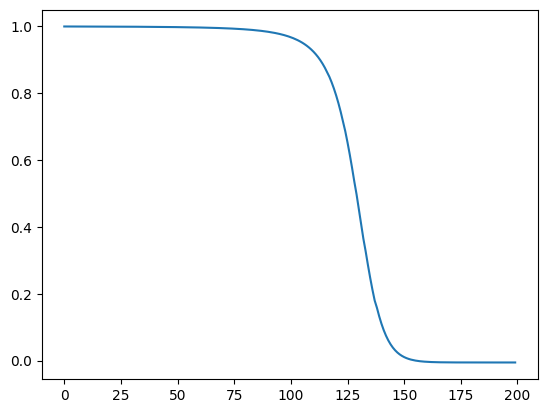

In [100]:
plt.plot(losses)

In [101]:
losses[-1]

-0.005618972178154991

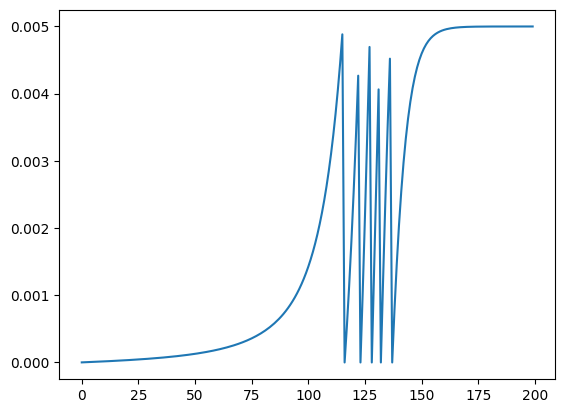

In [102]:
plt.plot(unitary_scores)

In [103]:
data_b01_sr = grad_descent_setup(psi_b01, 2, [np_I, np_X]*20)

In [104]:
for _ in range(200):
    grad_descent_step(*data_b01_sr, eta=0.1)

In [105]:
(*_, losses, unitary_scores) = data_b01_sr

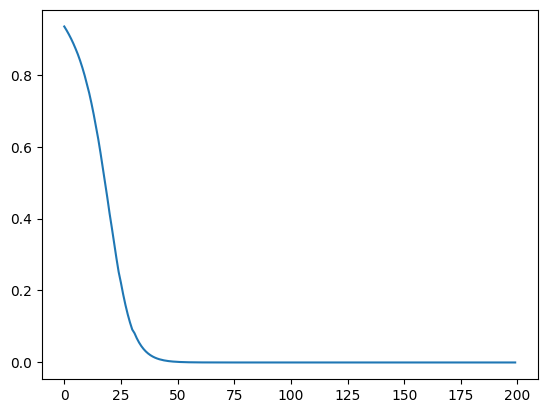

In [106]:
plt.plot(losses)

In [107]:
losses[-1]

-0.0015666398602185438

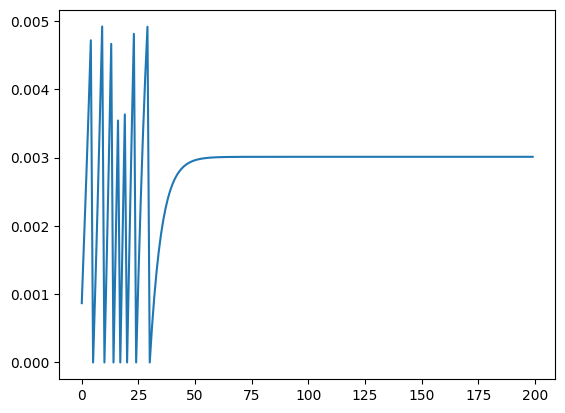

In [108]:
plt.plot(unitary_scores)

In [109]:
data_b01_sb = grad_descent_setup(psi_b01, 2, [np_X, np_X]*20)

In [110]:
for _ in range(300):
    grad_descent_step(*data_b01_sb, eta=0.1)

In [111]:
(*_, losses, unitary_scores) = data_b01_sb

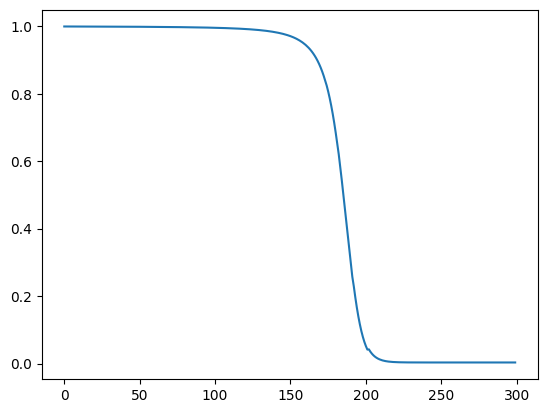

In [112]:
plt.plot(losses)

In [113]:
losses[-1]

0.0030780552672892147

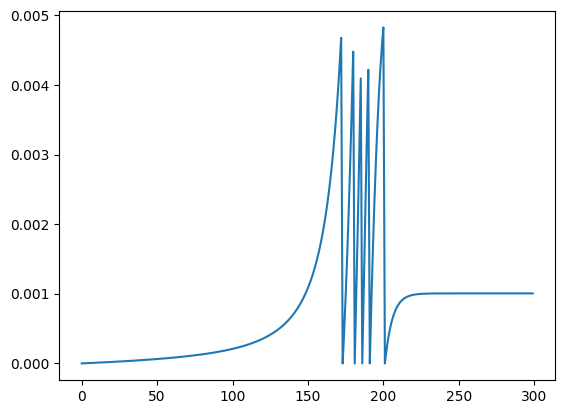

In [114]:
plt.plot(unitary_scores)

In [115]:
extract_left_right_cohomology_phases(
    data_b01_sl[3],
    data_b01_sr[3],
    data_b01_sl[4],
    data_b01_sr[4]
)

((-1-2.7665089151433557e-17j), (-1-2.7560688805525257e-17j))

In [116]:
extract_left_right_cohomology_phases(
    data_b01_sl[3],
    data_b01_sb[3],
    data_b01_sl[4],
    data_b01_sb[4]
)

((-1-6.227666357626422e-17j), (-1+4.1385487841061484e-17j))

In [117]:
extract_left_right_cohomology_phases(
    data_b01_sr[3],
    data_b01_sb[3],
    data_b01_sr[4],
    data_b01_sb[4]
)

((-1+4.1538137462877705e-17j), (-1+8.310067974360291e-17j))

### B=0.5

In [118]:
b_parameters = list(d['paramters']['B'] for d in loaded_data)

In [119]:
b_parameters

[1.3,
 0.4,
 1.7000000000000002,
 1.6,
 0.1,
 1.9000000000000001,
 1.2000000000000002,
 1.8,
 1.4000000000000001,
 2.0,
 0.6000000000000001,
 0.5,
 0.30000000000000004,
 1.5,
 0.9,
 0.7000000000000001,
 0.2,
 0.0,
 1.1,
 0.8,
 1.0]

That's annoying...

In [120]:
psi_05 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0.5
)   

In [121]:
data_b05_sl_w2 = grad_descent_setup(psi_05, 2, [np_X, np_I]*20)

In [122]:
for _ in range(500):
    grad_descent_step(*data_b05_sl_w2, eta=0.1)

In [123]:
(*_, losses, unitary_scores) = data_b05_sl_w2

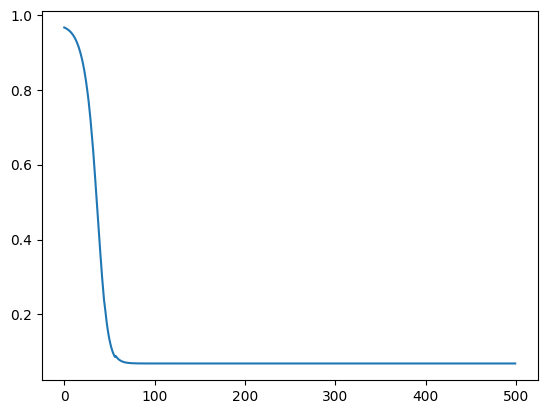

In [124]:
plt.plot(losses)

In [125]:
losses[-1]

0.06845781490598868

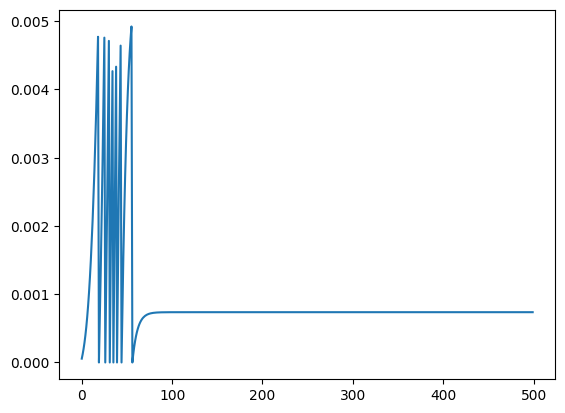

In [126]:
plt.plot(unitary_scores)

In [127]:
data_b05_sr_w2 = grad_descent_setup(psi_05, 2, [np_I, np_X]*20)

In [128]:
for _ in range(500):
    grad_descent_step(*data_b05_sr_w2, eta=0.1)

In [129]:
(*_, losses, unitary_scores) = data_b05_sr_w2

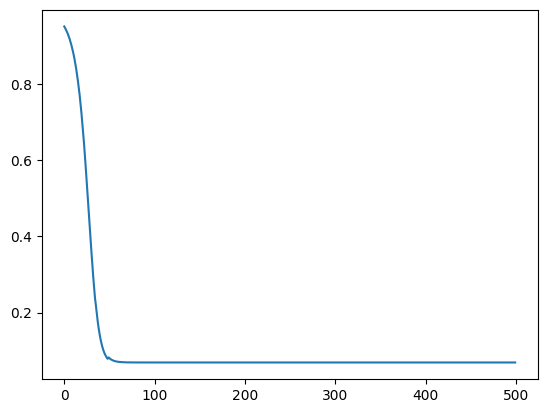

In [130]:
plt.plot(losses)

In [131]:
losses[-1]

0.06876288847406586

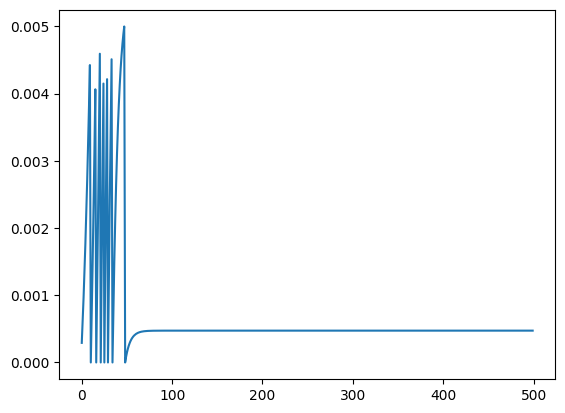

In [132]:
plt.plot(unitary_scores)

In [133]:
data_b05_sb_w2 = grad_descent_setup(psi_05, 2, [np_X, np_X]*20)

In [134]:
for _ in range(500):
    grad_descent_step(*data_b05_sb_w2, eta=0.1)

In [135]:
(*_, losses, unitary_scores) = data_b05_sb_w2

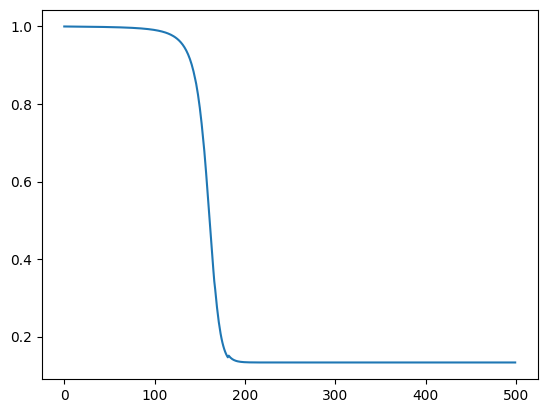

In [136]:
plt.plot(losses)

In [137]:
losses[-1]

0.1331960501603381

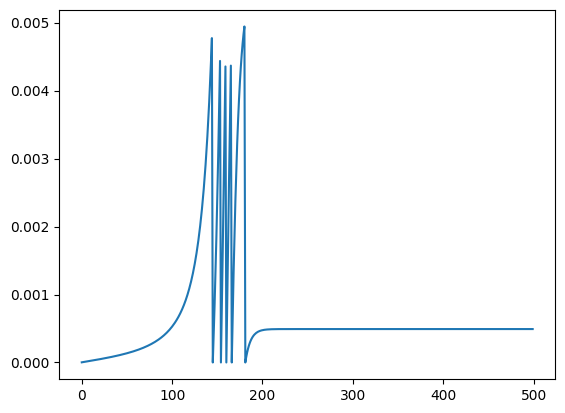

In [138]:
plt.plot(unitary_scores)

This loss doesn't seem to decrease if the unitary wdith is increased...

In [139]:
data_b05_sb_w4 = grad_descent_setup(psi_05, 4, [np_X, np_X]*20)

In [140]:
for _ in range(500):
    grad_descent_step(*data_b05_sb_w4, eta=0.1)

In [141]:
(*_, losses, unitary_scores) = data_b05_sb_w4

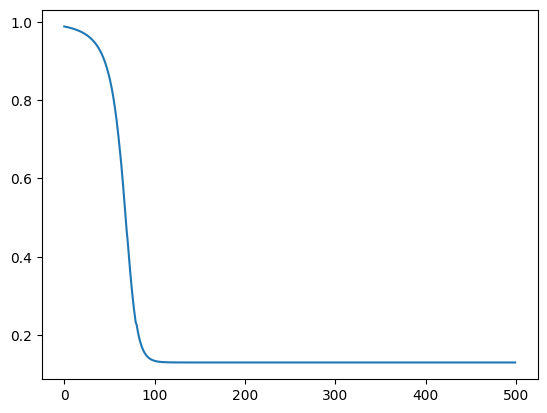

In [142]:
plt.plot(losses)

In [143]:
(losses[-1], unitary_scores[-1])

(0.1297777297120658, 0.002149092853471979)

In [144]:
data_b05_sb_w8 = grad_descent_setup(psi_05, 8, [np_X, np_X]*20)

In [153]:
for _ in range(500):
    grad_descent_step(*data_b05_sb_w8, eta=1)

In [154]:
(*_, losses, unitary_scores) = data_b05_sb_w8

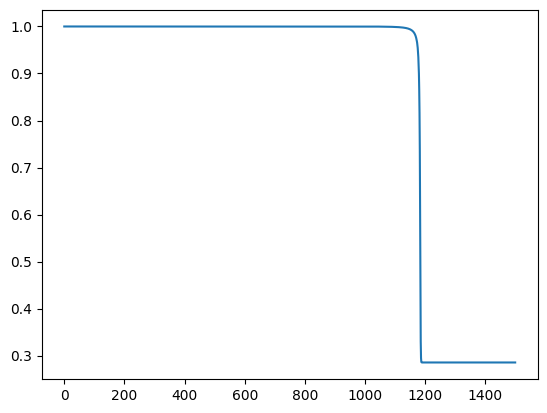

In [155]:
plt.plot(losses)

In [156]:
(losses[-1], unitary_scores[-1])

(0.2853518722284043, 0.001142864456302073)

In [297]:
data_b05_sb_w16 = grad_descent_setup(psi_05, 16, [np_X, np_X]*20)

In [298]:
loss = 1
while loss > 0.5:
    grad_descent_step(*data_b05_sb_w16, eta=20)
    (*_, losses, _) = data_b05_sb_w16
    loss = losses[-1]

In [301]:
for _ in range(500):
    grad_descent_step(*data_b05_sb_w16, eta=0.1)

In [302]:
(*_, losses, unitary_scores) = data_b05_sb_w16

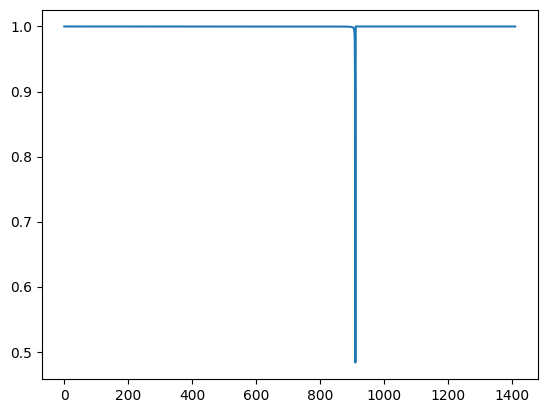

In [303]:
plt.plot(losses)

...huh

In [296]:
(losses[-1], unitary_scores[-1])

(0.47669019099449705, 1.1102230246251565e-15)

In [291]:
min(losses)

0.4023472865754024

Extract cohomology phases

In [234]:
extract_left_right_cohomology_phases(
    data_b05_sl_w2[3],
    data_b05_sr_w2[3],
    data_b05_sl_w2[4],
    data_b05_sr_w2[4]
)

((-1-1.383392213069203e-17j), (-1+1.1032504551845488e-16j))

In [235]:
extract_left_right_cohomology_phases(
    data_b05_sl_w2[3],
    data_b05_sb_w2[3],
    data_b05_sl_w2[4],
    data_b05_sb_w2[4]
)

((-1-8.289942759960176e-17j), (-1+0j))

In [236]:
extract_left_right_cohomology_phases(
    data_b05_sr_w2[3],
    data_b05_sb_w2[3],
    data_b05_sr_w2[4],
    data_b05_sb_w2[4]
)

((-1-1.0380662306880248e-16j), (-1+1.1060006166619062e-16j))

Not using this code anymore...
Add more unitaries, and continue learning.

In [314]:
left_unitaries = data_b05_sl_w2[3].copy()
right_unitaries = data_b05_sl_w2[4].copy()

In [315]:
identity_matrix = np.array([[1,0], [0,1]], dtype='complex128')

In [316]:
left_unitaries = [identity_matrix,] + left_unitaries
right_unitaries.append(identity_matrix)

In [317]:
len(left_unitaries), len(right_unitaries)

(3, 3)

In [321]:
padded_data_b05_sl_w3 = (
    data_b05_sl_w2[:3] +
    (left_unitaries, right_unitaries) +
    (starting_index - 1,) +
    data_b05_sl_w2[6:]
)

In [322]:
len(padded_data_b05_sl_w3) == len(data_b05_sl_w2)

True

In [323]:
for _ in range(500):
    grad_descent_step(*padded_data_b05_sl_w3, eta=0.1)

In [324]:
(*_, losses, unitary_scores) = padded_data_b05_sl_w3

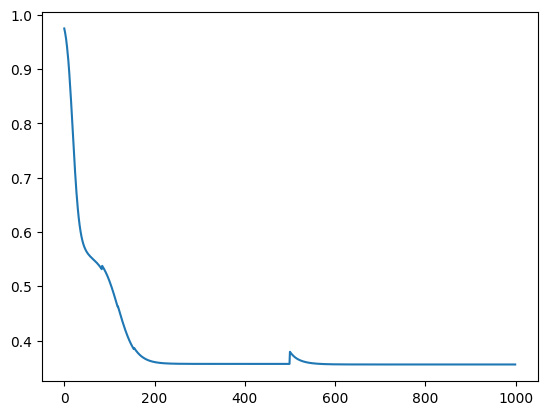

In [325]:
plt.plot(losses)

In [326]:
losses[-1]

0.35584537647591674

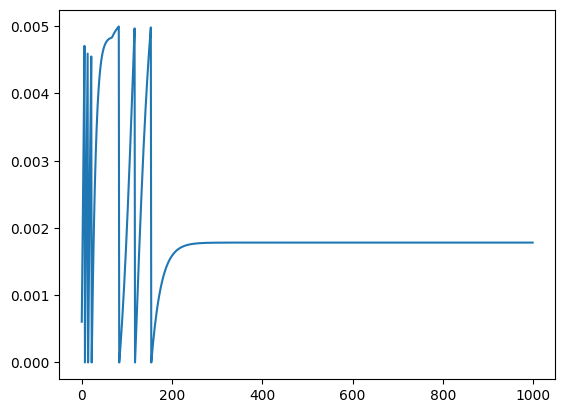

In [327]:
plt.plot(unitary_scores)

No improvement, so start again

In [307]:
data_b05_sl_w3 = grad_descent_setup(test_psi, 2, [np_X, np_I]*20)

In [309]:
for _ in range(500):
    grad_descent_step(*data_b05_sl_w2, eta=0.1)

In [310]:
(*_, losses, unitary_scores) = data_b05_sl_w2

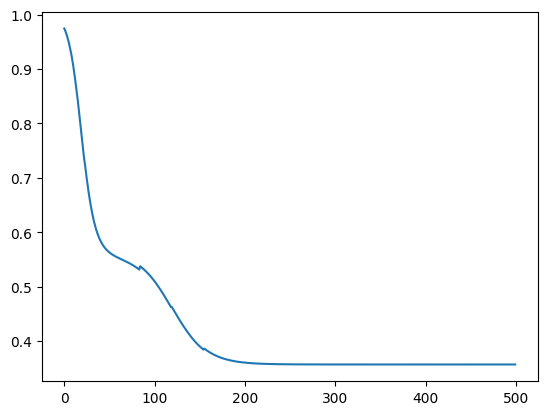

In [311]:
plt.plot(losses)

In [312]:
losses[-1]

0.35690881649743733

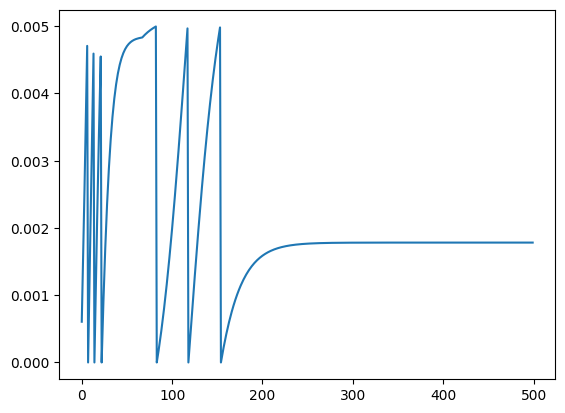

In [313]:
plt.plot(unitary_scores)

### B=0.9

In [237]:
psi_09 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0.9
)   

In [238]:
data_b09_sl_w2 = grad_descent_setup(psi_09, 2, [np_X, np_I]*30)

In [239]:
for _ in range(500):
    grad_descent_step(*data_b09_sl_w2, eta=0.1)

In [240]:
(*_, losses, unitary_scores) = data_b09_sl_w2

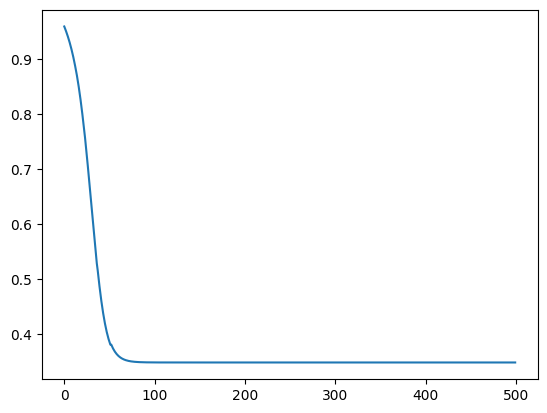

In [241]:
plt.plot(losses)

In [242]:
(losses[-1], unitary_scores[-1])

(0.34903122407072773, 0.0011358450623486505)

In [243]:
data_b09_sr_w2 = grad_descent_setup(psi_09, 2, [np_I, np_X]*30)

In [244]:
for _ in range(500):
    grad_descent_step(*data_b09_sr_w2, eta=0.1)

In [245]:
(*_, losses, unitary_scores) = data_b09_sr_w2

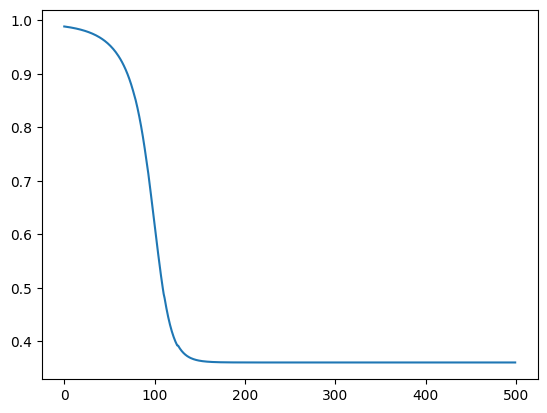

In [246]:
plt.plot(losses)

In [247]:
(losses[-1], unitary_scores[-1])

(0.3606021342416814, 0.002057565319054655)

In [248]:
data_b09_sb_w2 = grad_descent_setup(psi_09, 2, [np_X, np_X]*30)

In [249]:
for _ in range(500):
    grad_descent_step(*data_b09_sb_w2, eta=0.1)

In [250]:
(*_, losses, unitary_scores) = data_b09_sb_w2

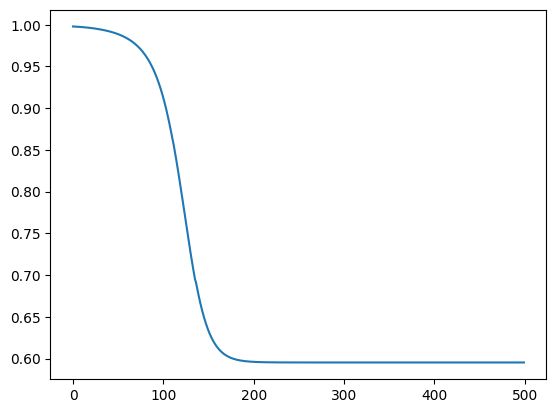

In [251]:
plt.plot(losses)

In [252]:
(losses[-1], unitary_scores[-1])

(0.5952404183078261, 0.0028562175835431525)

Extract cohomology phases

In [253]:
extract_left_right_cohomology_phases(
    data_b09_sl_w2[3],
    data_b09_sr_w2[3],
    data_b09_sl_w2[4],
    data_b09_sr_w2[4]
)

((-0.9999999999999999+2.0582131469894042e-17j), (-1-5.492673871663631e-17j))

In [254]:
extract_left_right_cohomology_phases(
    data_b09_sl_w2[3],
    data_b09_sb_w2[3],
    data_b09_sl_w2[4],
    data_b09_sb_w2[4]
)

((-1+5.529024971691232e-17j), (-1+7.709870254863923e-17j))

In [255]:
extract_left_right_cohomology_phases(
    data_b09_sr_w2[3],
    data_b09_sb_w2[3],
    data_b09_sr_w2[4],
    data_b09_sb_w2[4]
)

((-1-6.894062047576516e-17j), (-1+8.658833285659784e-17j))

### B=1.1

In [448]:
psi_11 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 1.1
)   

In [452]:
data_b11_sl_w2 = grad_descent_setup(psi_11, 2, [np_X, np_I]*30)

In [453]:
for _ in range(500):
    grad_descent_step(*data_b11_sl_w2, eta=0.1)

In [454]:
(*_, losses, unitary_scores) = data_b11_sl_w2

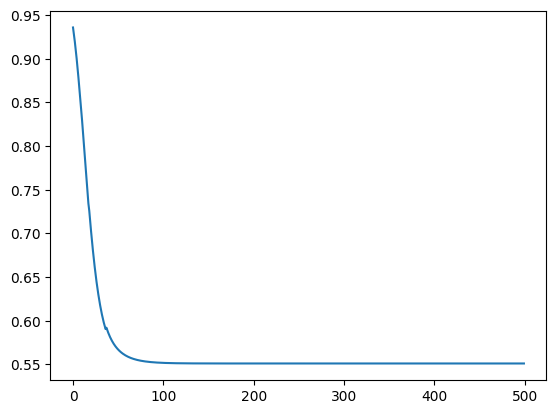

In [455]:
plt.plot(losses)

In [456]:
(losses[-1], unitary_scores[-1])

(0.5508770573736291, 0.0022556658046062328)

In [457]:
data_b11_sr_w2 = grad_descent_setup(psi_11, 2, [np_I, np_X]*30)

In [458]:
for _ in range(500):
    grad_descent_step(*data_b11_sr_w2, eta=0.1)

In [459]:
(*_, losses, unitary_scores) = data_b11_sr_w2

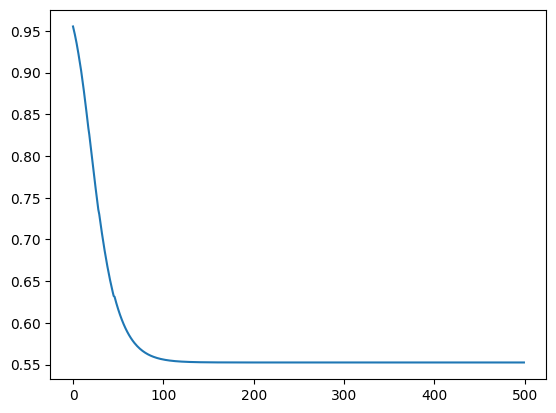

In [460]:
plt.plot(losses)

In [461]:
(losses[-1], unitary_scores[-1])

(0.5524292204259074, 0.004142732677526073)

In [462]:
data_b11_sb_w2 = grad_descent_setup(psi_11, 2, [np_X, np_X]*30)

In [463]:
for _ in range(500):
    grad_descent_step(*data_b11_sb_w2, eta=0.1)

In [464]:
(*_, losses, unitary_scores) = data_b11_sb_w2

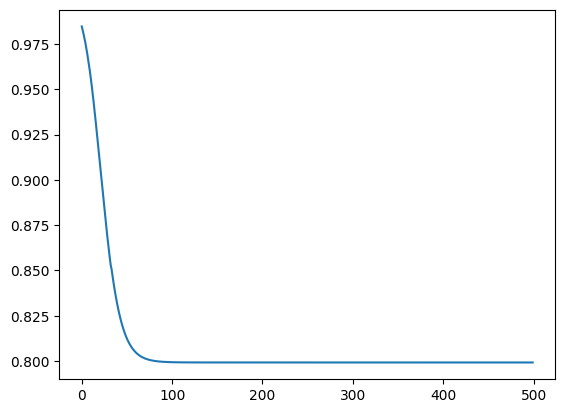

In [465]:
plt.plot(losses)

In [466]:
(losses[-1], unitary_scores[-1])

(0.7991723656158981, 0.0030952929775180937)

Extract cohomology phases

In [467]:
extract_left_right_cohomology_phases(
    data_b11_sl_w2[3],
    data_b11_sr_w2[3],
    data_b11_sl_w2[4],
    data_b11_sr_w2[4]
)

((1-5.5379015923639576e-17j), (1-4.1547646739246686e-17j))

In [468]:
extract_left_right_cohomology_phases(
    data_b11_sl_w2[3],
    data_b11_sb_w2[3],
    data_b11_sl_w2[4],
    data_b11_sb_w2[4]
)

((1-4.1581942719849055e-17j), (1+2.76590727016589e-17j))

In [469]:
extract_left_right_cohomology_phases(
    data_b11_sr_w2[3],
    data_b11_sb_w2[3],
    data_b11_sr_w2[4],
    data_b11_sb_w2[4]
)

((1-2.7747125816421663e-17j), (1-2.42494969546378e-17j))

## B=2

In [147]:
psi_b2 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 2
)   

In [194]:
data_b2_sl = grad_descent_setup(psi_b2, 8, [np_X, np_I]*20)

In [203]:
for _ in range(500):
    grad_descent_step(*data_b2_sl, eta=0.1)

In [204]:
(*_, losses, unitary_scores) = data_b2_sl

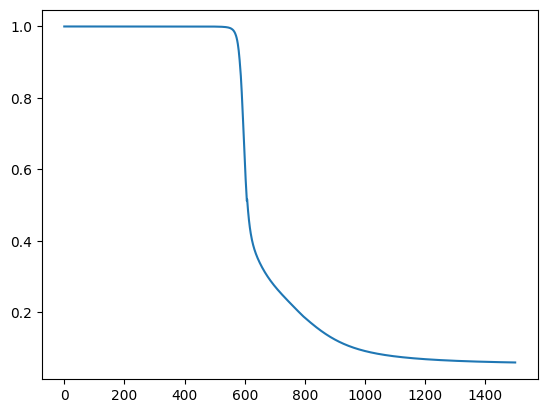

In [205]:
plt.plot(losses)

In [206]:
losses[-1]

0.05960599795016419

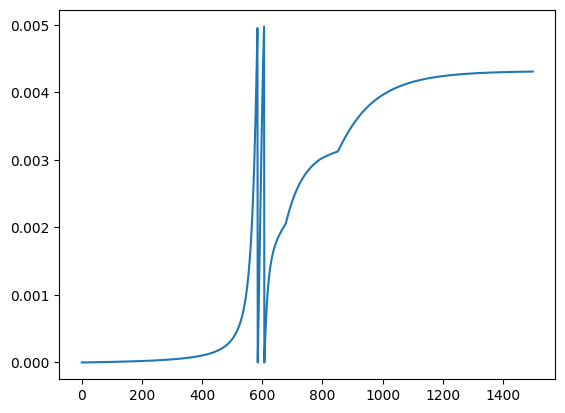

In [207]:
plt.plot(unitary_scores)

In [277]:
data_b2_sr = grad_descent_setup(psi_b2, 8, [np_I, np_X]*20)

In [286]:
for _ in range(100):
    grad_descent_step(*data_b2_sr, eta=0.01)

In [287]:
(*_, losses, unitary_scores) = data_b2_sr

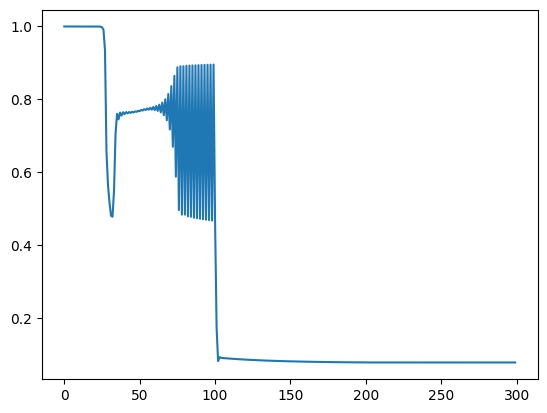

In [288]:
plt.plot(losses)

In [289]:
losses[-1]

0.07835060842494979

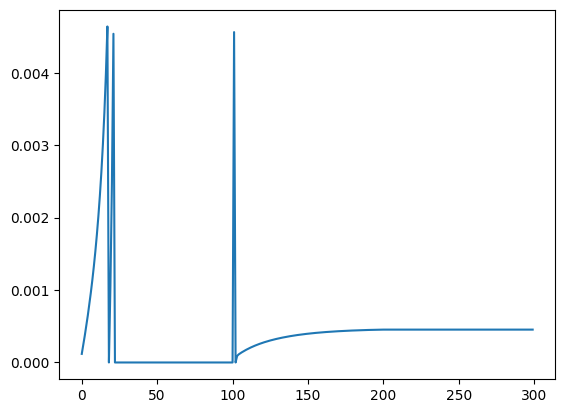

In [290]:
plt.plot(unitary_scores)

In [292]:
data_b2_sb = grad_descent_setup(psi_b2, 8, [np_X, np_X]*20)

In [296]:
for _ in range(100):
    grad_descent_step(*data_b2_sb, eta=0.03)

In [297]:
(*_, losses, unitary_scores) = data_b2_sb

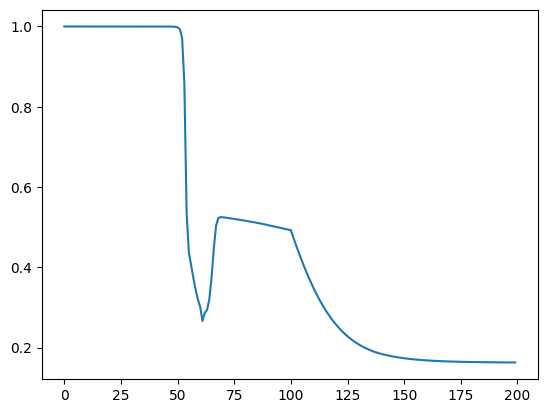

In [298]:
plt.plot(losses)

In [299]:
losses[-1]

0.16302224522649478

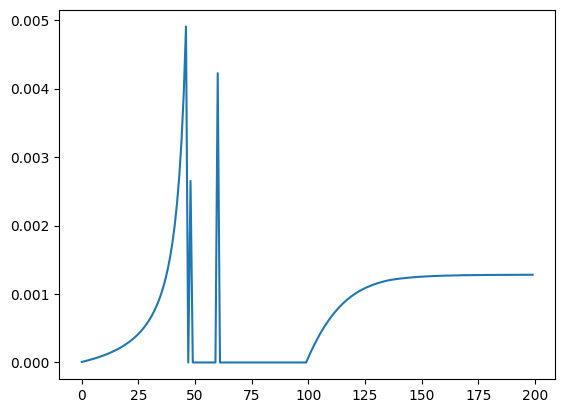

In [300]:
plt.plot(unitary_scores)

In [301]:
extract_left_right_cohomology_phases(
    data_b2_sl[3],
    data_b2_sr[3],
    data_b2_sl[4],
    data_b2_sr[4]
)

((1+3.592437520339363e-18j), (1-5.861598361481182e-17j))

In [302]:
extract_left_right_cohomology_phases(
    data_b2_sl[3],
    data_b2_sb[3],
    data_b2_sl[4],
    data_b2_sb[4]
)

((1-4.0749306578459838e-19j), (1+6.586329295020432e-17j))

In [303]:
extract_left_right_cohomology_phases(
    data_b2_sr[3],
    data_b2_sb[3],
    data_b2_sr[4],
    data_b2_sb[4]
)

((1+1.4093646537662805e-16j), (1+5.022565751916143e-17j))

# Old code

In [116]:
def matrix_element_gradient(psi, symmetry_operations, left_unitaries,
                            right_unitaries, unitary_index, starting_psi_index):
    left_npc_unitaries = [to_npc_array(u) for u in left_unitaries]
    right_npc_unitaries = [to_npc_array(u) for u in right_unitaries]

    assert (unitary_index >= 0) and (unitary_index < len(left_unitaries) + len(right_unitaries))
    if unitary_index < len(left_unitaries):
        left_ops = left_npc_unitaries[:unitary_index]
        right_ops = left_npc_unitaries[unitary_index+1:] + symmetry_operations + right_npc_unitaries
    else:
        shifted_index = unitary_index - len(left_unitaries)
        left_ops = left_npc_unitaries + symmetry_operations + right_npc_unitaries[:shifted_index]
        right_ops = right_npc_unitaries[shifted_index+1:]

    starting_index = get_starting_index(psi, symmetry_operations, left_unitaries, right_unitaries)

    out = np.zeros((2,2),dtype='complex')
    
    for i in range(2):
        for j in range(2):
            delta_U = np.zeros((2,2),dtype='complex')
            delta_U[i,j] = 1
            ops_list = left_ops + [to_npc_array(delta_U),] + right_ops
            out[i,j] = psi.expectation_value_multi_sites(ops_list, starting_psi_index)
    
    return out

In [77]:
def all_matrix_element_gradients(psi, symmetry_operations, left_unitaries, right_unitaries):
    left_outs = list()

    for unitary_index in range(len(left_unitaries)):
        left_outs.append(matrix_element_gradient(psi, symmetry_operations, left_unitaries, right_unitaries, unitary_index))

    right_outs = list()

    for unitary_index in range(len(right_unitaries)):
        right_outs.append(matrix_element_gradient(psi, symmetry_operations, left_unitaries, right_unitaries, unitary_index+len(left_unitaries)))

    return (left_outs, right_outs)

In [149]:
def update(psi, symmetry_operations, left_unitaries, right_unitaries, losses, unitary_test_scores, eta=0.03, unitary_tol = 0.005):
    M = matrix_element(psi, symmetry_operations, left_unitaries, right_unitaries)

    left_gradients, right_gradients = all_matrix_element_gradients(psi, symmetry_operations, left_unitaries, right_unitaries)

    for u,d in zip(left_unitaries, left_gradients):
        grad = -2*M*np.conj(d)
        u += -eta*projector(u, grad)

    for u,d in zip(right_unitaries, right_gradients):
        grad = -2*M*np.conj(d)
        u += -eta*projector(u, grad)

    losses.append(loss(psi, symmetry_operations, left_unitaries, right_unitaries))

    all_unitaries = left_unitaries + right_unitaries

    any_unitary_fail = any(
        unitary_test(u) > unitary_tol
        for u in all_unitaries
    )

    if any_unitary_fail:
        for i in range(len(left_unitaries)):
            u = left_unitaries[i]
            left_unitaries[i] = unitarize_matrix(u)
        for i in range(len(right_unitaries)):
            u = right_unitaries[i]
            right_unitaries[i] = unitarize_matrix(u)

    current_unitary_test_scores = [unitary_test(u) for u in all_unitaries]
    unitary_test_scores.append(current_unitary_test_scores)
    
    pass

In [100]:
def sample_unitaries(n):
    unitary_sampler = unitary_group(2)

    samples = [unitary_sampler.rvs() for _ in range(n)]

    return samples

In [150]:
single_losses = list()
single_unitary_scores = list()

left_unitaries = sample_unitaries(1)
right_unitaries = sample_unitaries(1)

In [167]:
single_symmetry_operations = transverse_cluster_symmetry_operation("single", 10)

In [151]:
for i in range(100):
    update(psi, symmetry_operations, left_unitaries, right_unitaries, single_losses, single_unitary_scores, eta=0.03)

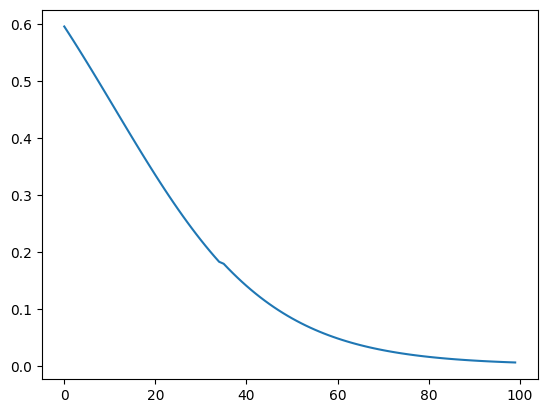

In [152]:
plt.plot(single_losses)

In [153]:
single_losses[-1]

0.006846379175071915

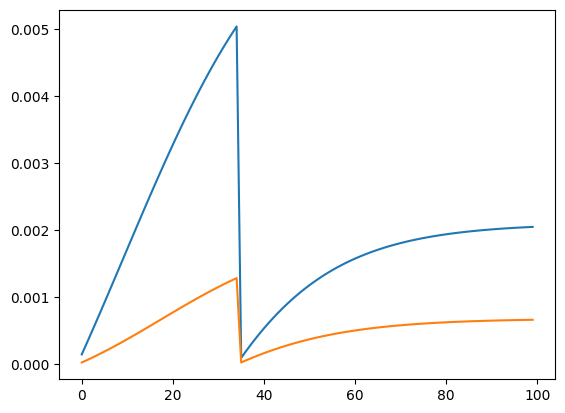

In [154]:
plt.plot(list(zip(*single_unitary_scores))[0])
plt.plot(list(zip(*single_unitary_scores))[1])

extract phase

In [170]:
single_phase = np.conj(matrix_element(psi, single_symmetry_operations, left_unitaries, right_unitaries))

In [37]:
unitary_tol = 0.005

In [38]:
def unitary_test(U):
    return np.max(np.abs(U.conj().T.dot(U)-np.identity(len(U))))

In [39]:
def unitarize_matrix(U):
    L,S,R = np.linalg.svd(U)
    return L.dot(R)

In [156]:
double_losses = list()
double_unitary_scores = list()

double_left_unitaries = sample_unitaries(2)
double_right_unitaries = sample_unitaries(2)

double_symmetry_operations = transverse_cluster_symmetry_operation("both", 10)

In [165]:
for i in range(100):
    update(
        psi,
        double_symmetry_operations,
        double_left_unitaries,
        double_right_unitaries,
        double_losses,
        double_unitary_scores,
        eta=0.03
    )

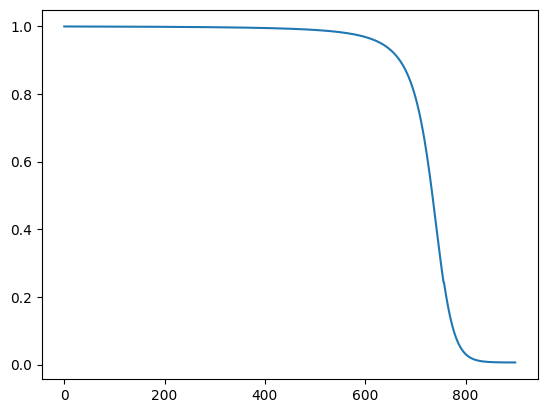

In [166]:
plt.plot(double_losses)

In [171]:
double_phase = np.conj(matrix_element(psi, double_symmetry_operations, double_left_unitaries, double_right_unitaries))

In [172]:
double_phase

(0.6171256903536819+0.7827851758858232j)

# Extract cohomology class

In [178]:
U1 = single_phase*right_unitaries[0]
U2 = double_phase*double_right_unitaries[0]

In [179]:
U1.dot(U2).dot(np.conj(U1.T)).dot(np.conj(U2.T))

array([[-0.98575714-0.06602374j, -0.00320238-0.01708454j],
       [ 0.00320238-0.01708454j, -0.98575714+0.06602374j]])

Close enough to -1... where are the errors coming in?

In [180]:
U1 = single_phase*right_unitaries[0]
U2 = double_phase*double_right_unitaries[1]

In [181]:
U1.dot(U2).dot(np.conj(U1.T)).dot(np.conj(U2.T))

array([[ 0.9876098 -1.14769004e-05j, -0.00226331+1.58932079e-02j],
       [ 0.00226331+1.58932079e-02j,  0.9876098 +1.14769004e-05j]])

But not it's closer to +1...! Although perhaps this comparison doesn't make sense...
I need to work through this analytically.

# Sample losses

In [50]:
random_losses = list()

for i in range(100):
    U1 = unitary_sampler.rvs()
    U2 = unitary_sampler.rvs()
    U3 = unitary_sampler.rvs()
    U4 = unitary_sampler.rvs()

    ops_list = list()

    ops_list.append(to_npc_array(U1))
    ops_list.append(to_npc_array(U2))

    ops_list.extend([npc_X, npc_X]*num_symmetry_site_pairs)
    ops_list.append(to_npc_array(U3))
    ops_list.append(to_npc_array(U4))

    M = psi.expectation_value_multi_sites(ops_list, starting_index-1)

    M_loss = 1-(np.abs(M)**2)
    
    random_losses.append(M_loss)

In [51]:
min(random_losses)

0.9455882983600918